In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import seaborn as sns # for plot visualization
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
weather_df = pd.read_csv(r'C:\Users\manis\Downloads\Weather_data.csv', parse_dates=['datetime_utc'], index_col='datetime_utc')
weather_df.head()

,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
datetime_utc,,,,,,,,,,,,,,,,,,,
1996-11-01 11:00:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1996-11-01 12:00:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
1996-11-01 13:00:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
1996-11-01 14:00:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
1996-11-01 16:00:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


Here we are going to consider only few of the columns which seems important from some basic EDA and time series prediction's point of view. At the same time renaming with some better ones.

In [3]:
weather_df = weather_df.loc[:,[' _conds', ' _hum', ' _tempm']]
weather_df = weather_df.rename(index=str, columns={' _conds': 'condition', ' _hum': 'humidity', ' _pressurem': 'pressure', ' _tempm': 'temprature'})
print(f'dataset shape (rows, columns) - {weather_df.shape}')
weather_df.head()

dataset shape (rows, columns) - (98913, 3)


,condition,humidity,temprature
datetime_utc,,,
1996-11-01 11:00:00,Smoke,27.0,30.0
1996-11-01 12:00:00,Smoke,32.0,28.0
1996-11-01 13:00:00,Smoke,44.0,24.0
1996-11-01 14:00:00,Smoke,41.0,24.0
1996-11-01 16:00:00,Smoke,47.0,23.0


In [4]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98913 entries, 1996-11-01 11:00:00 to 2016-11-30 21:00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   condition   98845 non-null  object 
 1   humidity    98160 non-null  float64
 2   temprature  98244 non-null  float64
dtypes: float64(2), object(1)
memory usage: 3.0+ MB


It shows 'index' as object type which needs to be converted to datetime otherwise we won't be able to perform scaling during time series analysis.

In [5]:
weather_df.index = pd.to_datetime(weather_df.index)
weather_df.index

DatetimeIndex(['1996-11-01 11:00:00', '1996-11-01 12:00:00',
               '1996-11-01 13:00:00', '1996-11-01 14:00:00',
               '1996-11-01 16:00:00', '1996-11-01 17:00:00',
               '1996-11-01 18:00:00', '1996-11-01 19:00:00',
               '1996-11-01 20:00:00', '1996-11-01 21:00:00',
               ...
               '2016-11-30 10:00:00', '2016-11-30 10:30:00',
               '2016-11-30 11:00:00', '2016-11-30 11:30:00',
               '2016-11-30 12:00:00', '2016-11-30 12:30:00',
               '2016-11-30 13:00:00', '2016-11-30 15:00:00',
               '2016-11-30 18:00:00', '2016-11-30 21:00:00'],
              dtype='datetime64[ns]', name='datetime_utc', length=98913, freq=None)

Seems fine. Now lets check the total number (and percent) of missing values in each columns.

## Data Cleaning

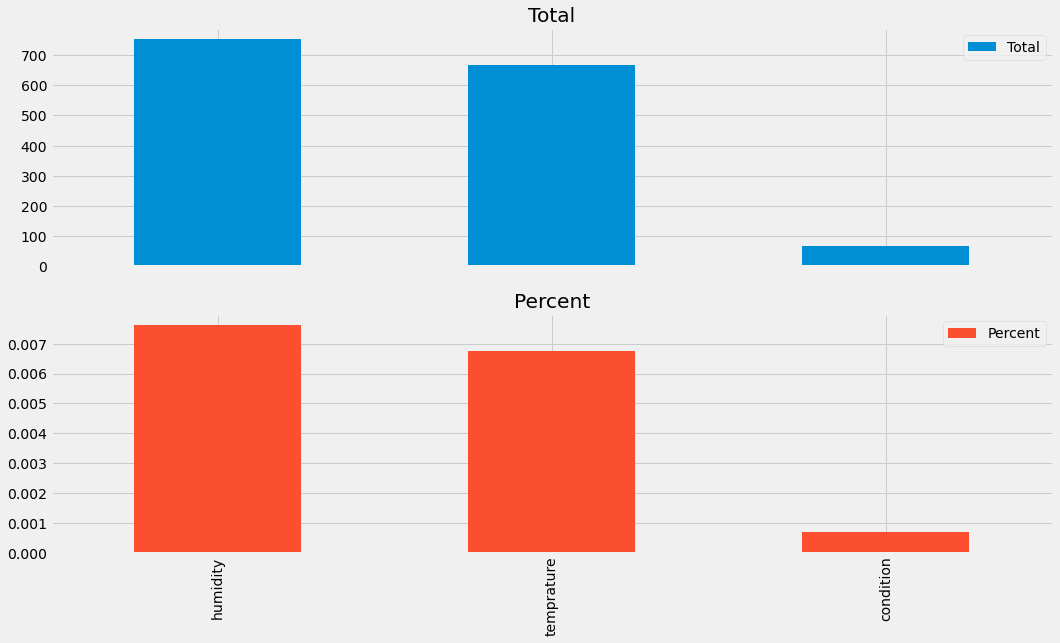

In [6]:
def list_and_visualize_missing_data(dataset):
    # Listing total null items and its percent with respect to all nulls
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = ((dataset.isnull().sum())/(dataset.isnull().count())).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data[missing_data.Total > 0]
    
    missing_data.plot.bar(subplots=True, figsize=(16,9))

list_and_visualize_missing_data(weather_df)

Not many values are missing, but it will still be great to fill the missing ones instead of removing entire row.

In [7]:
# will fill with previous valid value
weather_df.ffill(inplace=True)
weather_df[weather_df.isnull()].count()

condition     0
humidity      0
temprature    0
dtype: int64

In [8]:
weather_df.describe()

,humidity,temprature
count,98913.000000,98913.000000
mean,57.823522,25.564587
std,23.768628,8.470290
min,4.000000,1.000000
25%,39.000000,19.000000
50%,58.000000,27.000000
75%,78.000000,32.000000
max,243.000000,90.000000


It is showing maximum temprature as 90 and max humidity as 243 which is non-realistic, so is an outlier. We need to treat these outliers.

In [9]:
weather_df = weather_df[weather_df.temprature < 50]
weather_df = weather_df[weather_df.humidity <= 100]

## Exploratory Data Analysis & Visualizations


Let's checkout the most common weather condition type in Delhi.

Text(0, 0.5, 'Percent')

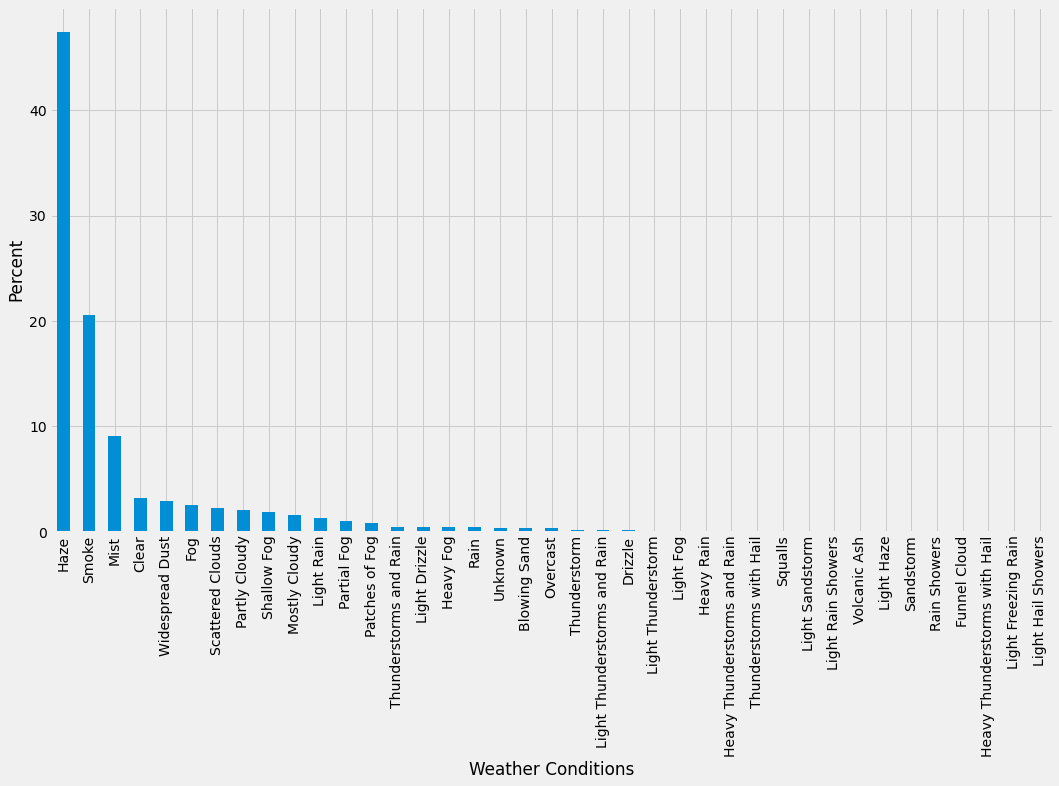

In [10]:
weather_condition = (weather_df.condition.value_counts()/(weather_df.condition.value_counts().sum()))*100
weather_condition.plot.bar(figsize=(16,9))
plt.xlabel('Weather Conditions')
plt.ylabel('Percent')

Oh, it is really bad that mostly Delhi has Hazy and smoky weather conditions, it shows the level of pollution city has.

Let's see how plot for all year's temprature and humidity looks like.

array([<AxesSubplot:xlabel='datetime_utc'>,
       <AxesSubplot:xlabel='datetime_utc'>], dtype=object)

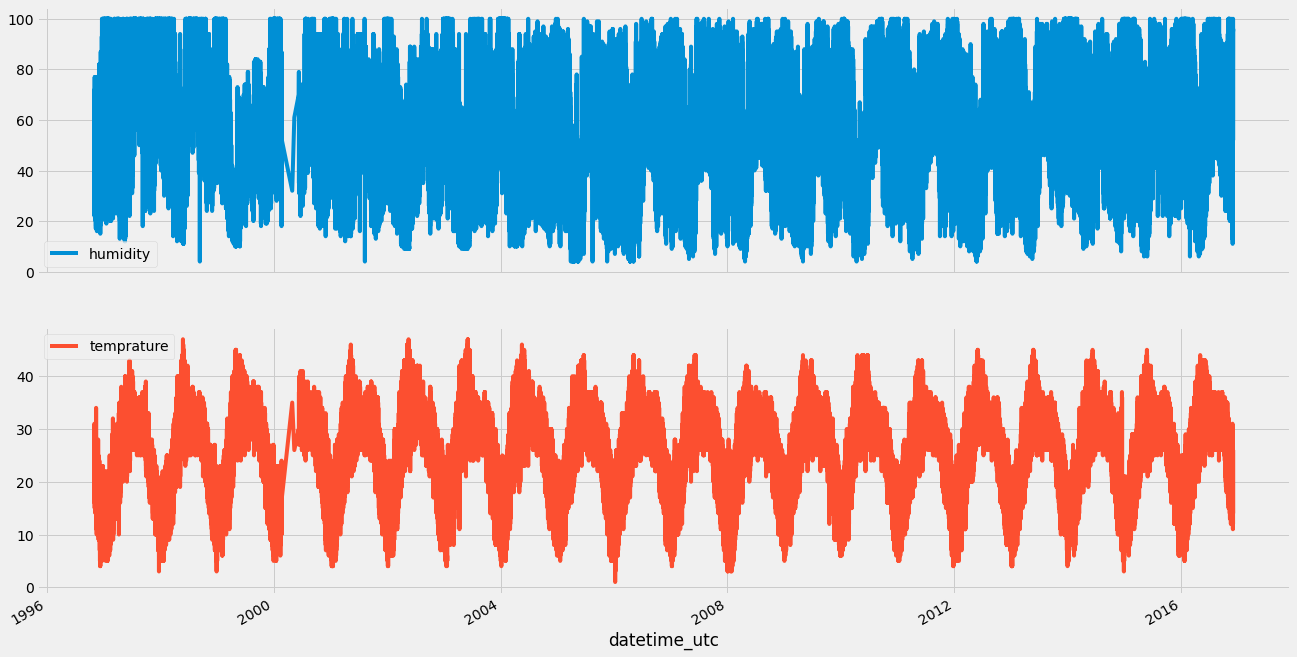

In [11]:
weather_df.plot(subplots=True, figsize=(20,12))

It seems overplotted, let's plot for only two years 2015 and 2016, it will give us the clear picture of seasonality and tread.

array([<AxesSubplot:xlabel='datetime_utc'>,
       <AxesSubplot:xlabel='datetime_utc'>], dtype=object)

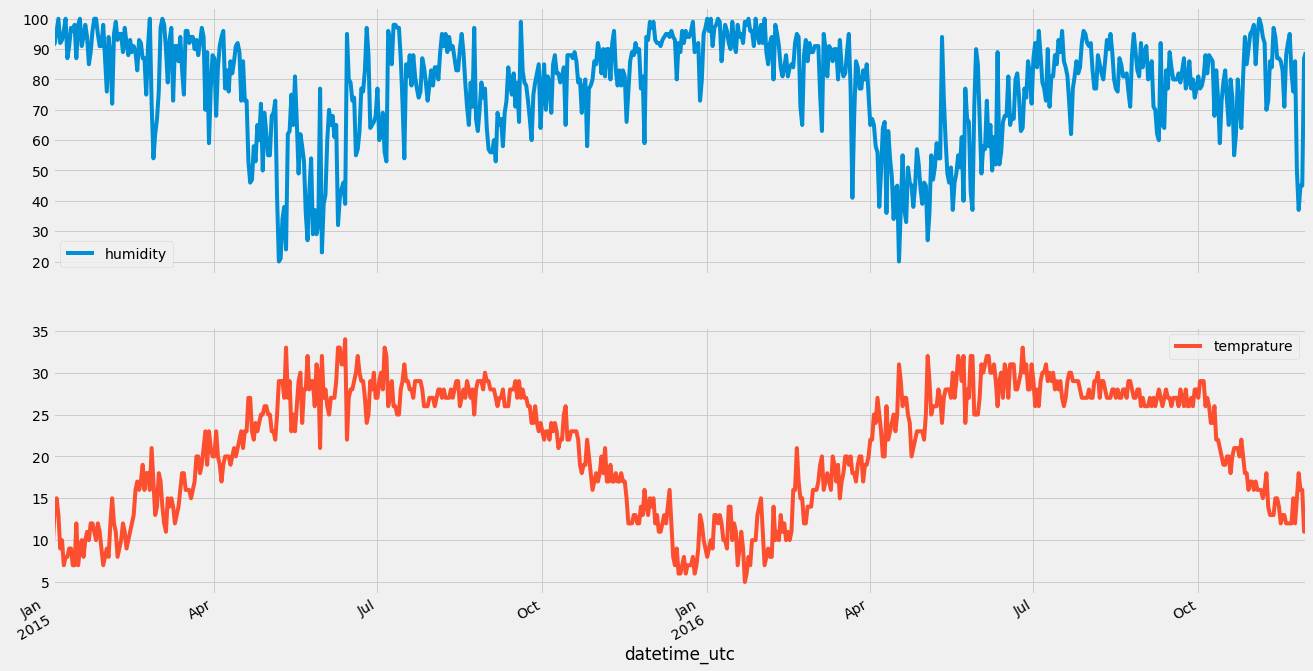

In [12]:
weather_df['2015':'2016'].resample('D').fillna(method='pad').plot(subplots=True, figsize=(20,12))

So it shows that mid two quarter are hotter than first and last, humidity varies accordingly.

In [13]:
train_df = weather_df['2000':'2015'].resample('M').mean().fillna(method='pad')
train_df.drop(columns='humidity', axis=1, inplace=True)
test_df = weather_df['2016':'2017'].resample('M').mean().fillna(method='pad')
test_df.drop(columns='humidity', axis=1, inplace=True)

Check Stationarity
So above plots shows that we do have seasonality but there is no trend. Let's check for below necessary conditions:


Constant mean

Constant variance

An auto co-variance that does not depend on time

In [14]:
# check rolling mean and rolling standard deviation
def plot_rolling_mean_std(ts):
    rolling_mean = ts.rolling(12).mean()
    rolling_std = ts.rolling(12).std()
    plt.figure(figsize=(22,10))

    plt.plot(ts, label='Actual Mean')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()

In [15]:
# Augmented Dickey–Fuller test
def perform_dickey_fuller_test(ts):
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('Critical Values:' ,result[4])

In Dickey-Fuller test, we need only test_statics and critical_value to know if it is stationary or not

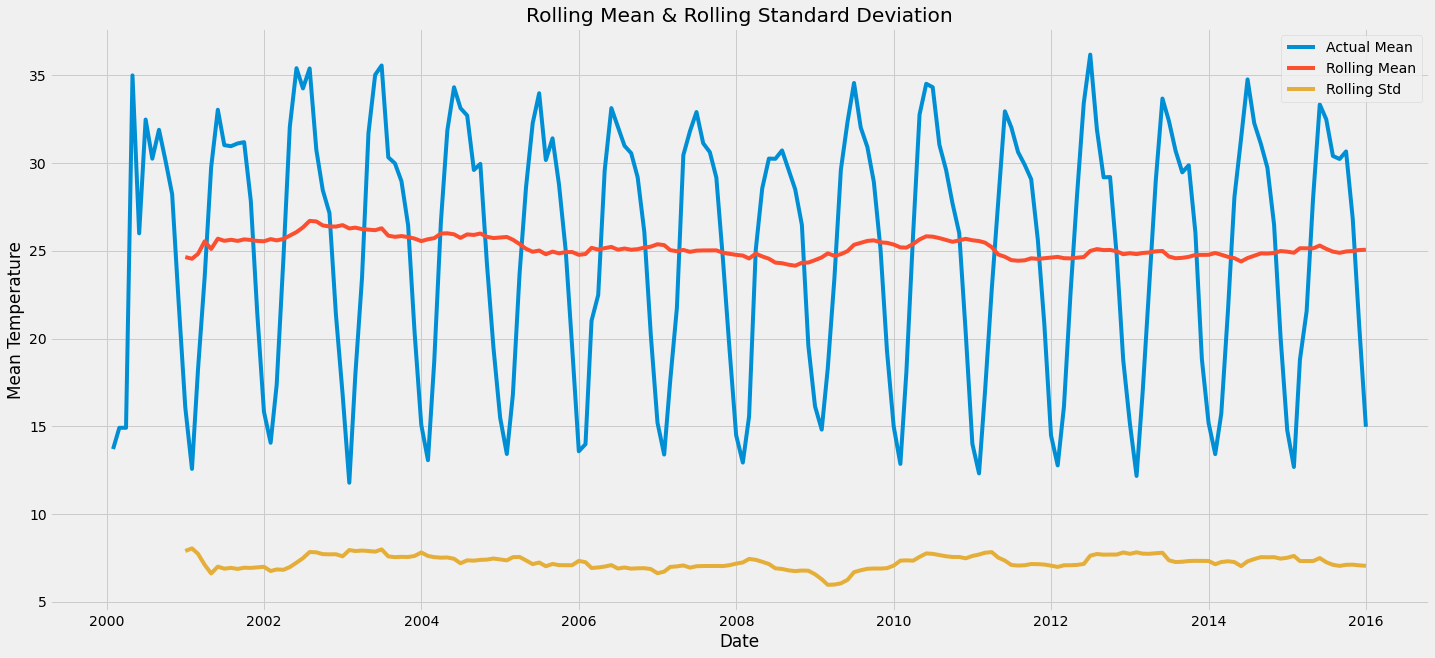

Test statistic:  -2.1269952502980254
Critical Values: {'1%': -3.4674201432469816, '5%': -2.877826051844538, '10%': -2.575452082332012}


In [16]:
# check stationary: mean, variance(std)and adfuller test
plot_rolling_mean_std(train_df.temprature)
perform_dickey_fuller_test(train_df.temprature)

We have constant Mean and Variance, and our Test statistic is less than Critical Values, so we already have stationary Time series. So our 'd' value will become 0 in ARIMA Model.

Consider a case if it was non-stationary, in that case we would use below techniques to make it stationary

Make Stationary For non-stationary to stationary conversion, we can use any of the below technique :

Decomposing
Differencing
Here, we are preferring Differencing because it is very straight forward. We would use below co-relation plots to identify the order of differencing

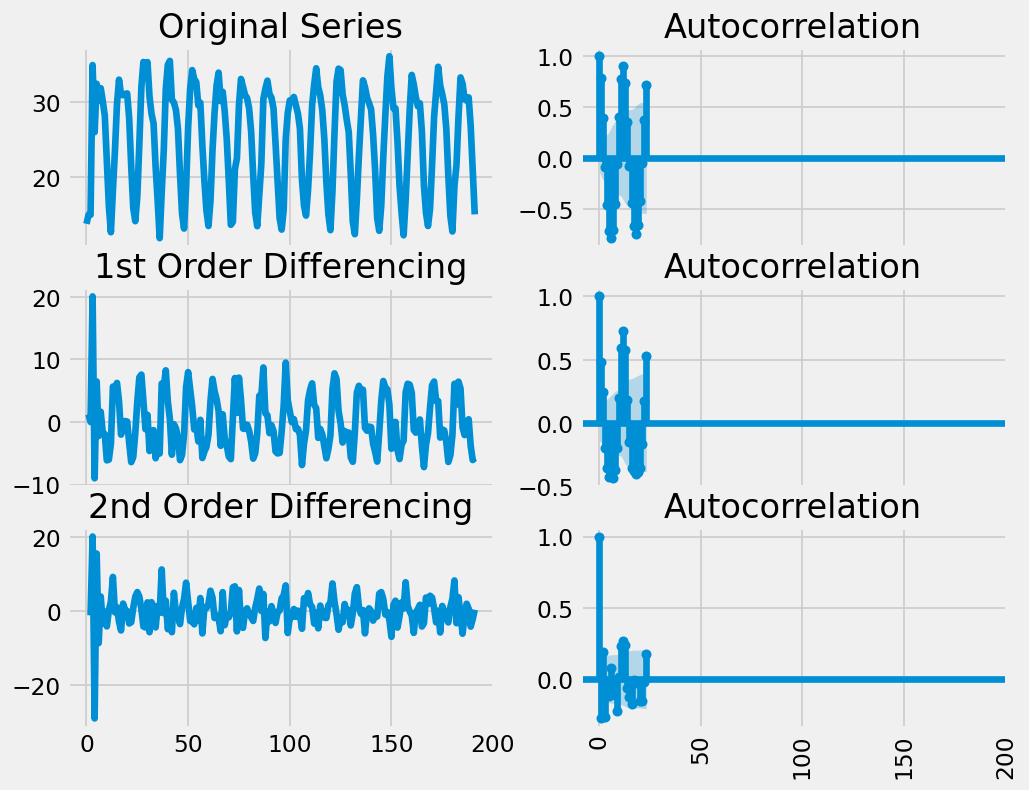

In [17]:
# Original Series
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(train_df.values); 
axes[0, 0].set_title('Original Series')
plot_acf(train_df.values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train_df.temprature.diff().values); 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(train_df.diff().dropna().values,ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train_df.temprature.diff().diff().values); 
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train_df.diff().diff().dropna().values,ax=axes[2, 1])

plt.xticks(rotation='vertical')
plt.show()

As you can see here the first series itself is perfectly stationary, So we don't need any differencing here

C:\Users\manis\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


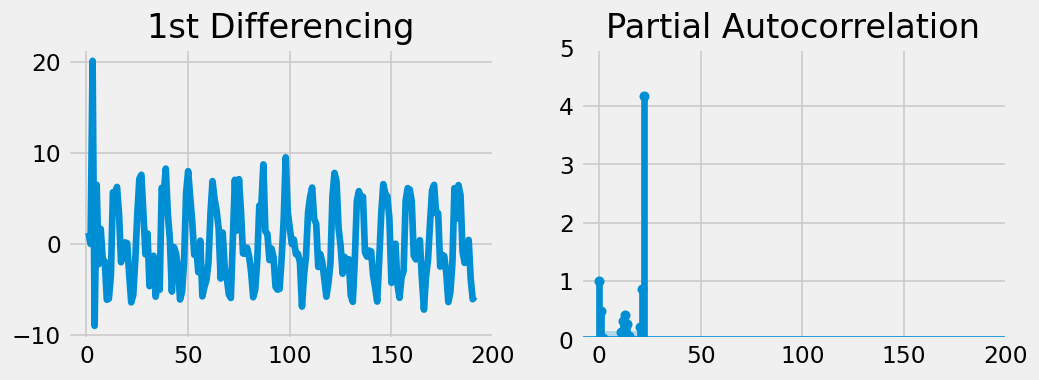

In [18]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train_df.diff().values); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(train_df.diff().dropna().values, ax=axes[1])

plt.show()

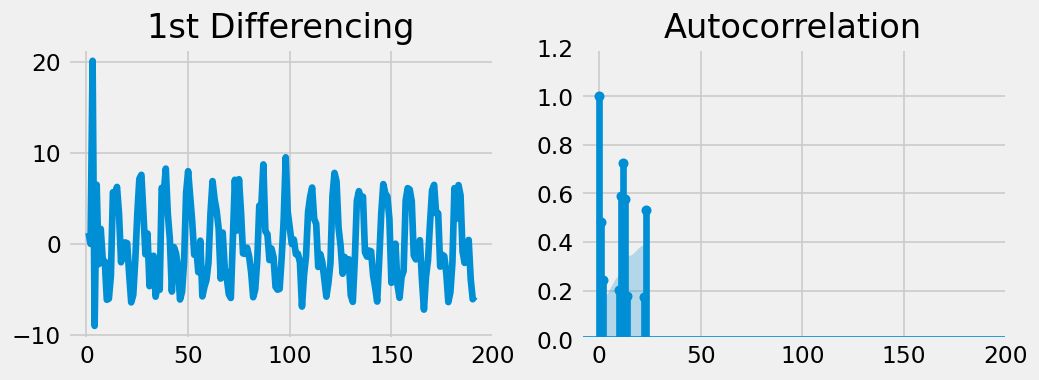

In [19]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train_df.diff().values); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(train_df.diff().dropna().values, ax=axes[1])

plt.show()

## Timeseries Analysis (ARIMA Model)

C:\Users\manis\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


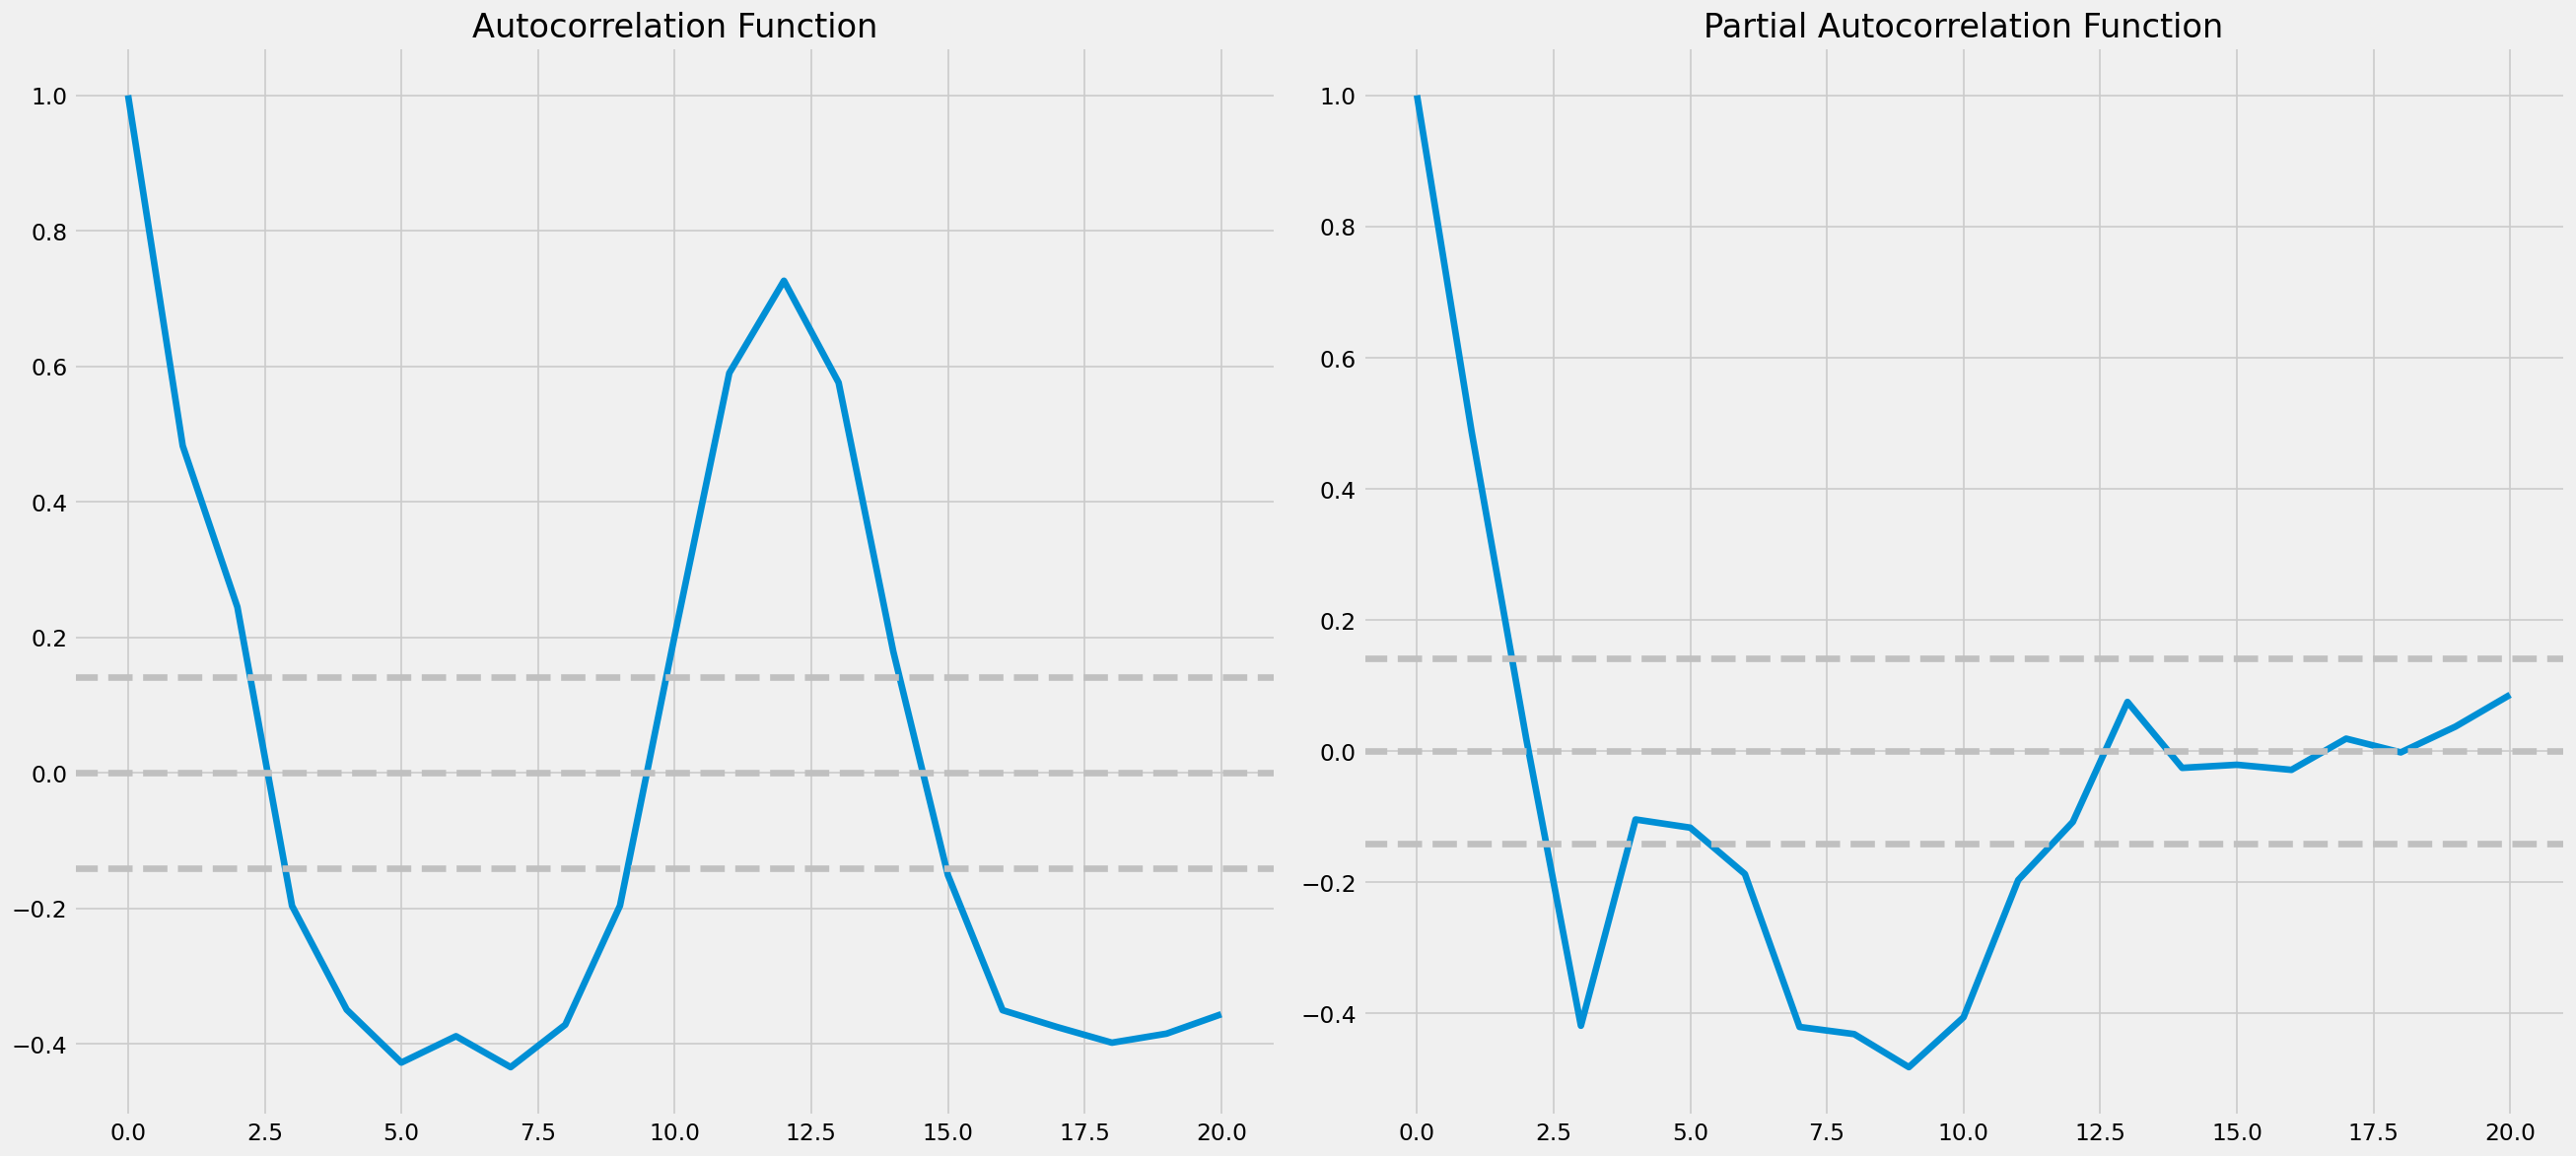

In [20]:
acf_lag = acf(train_df.diff().dropna().values, nlags=20)
pacf_lag = pacf(train_df.diff().dropna().values, nlags=20, method='ols')

plt.figure(figsize=(22,10))

plt.subplot(121)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.title("Autocorrelation Function")

plt.subplot(122)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

In [21]:
model = ARIMA(train_df.values, order=(2,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\manis\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  192
Model:                     ARMA(2, 2)   Log Likelihood                -454.355
Method:                       css-mle   S.D. of innovations              2.552
Date:                Thu, 03 Mar 2022   AIC                            920.709
Time:                        14:12:26   BIC                            940.254
Sample:                             0   HQIC                           928.625
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.1917      0.119    211.045      0.000      24.958      25.426
ar.L1.y        1.6785      0.024     69.835      0.000       1.631       1.726
ar.L2.y       -0.9519      0.023    -41.164      0.0

In [22]:
model = ARIMA(train_df.values, order=(2,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\manis\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  192
Model:                     ARMA(2, 2)   Log Likelihood                -454.355
Method:                       css-mle   S.D. of innovations              2.552
Date:                Thu, 03 Mar 2022   AIC                            920.709
Time:                        14:12:27   BIC                            940.254
Sample:                             0   HQIC                           928.625
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.1917      0.119    211.045      0.000      24.958      25.426
ar.L1.y        1.6785      0.024     69.835      0.000       1.631       1.726
ar.L2.y       -0.9519      0.023    -41.164      0.0

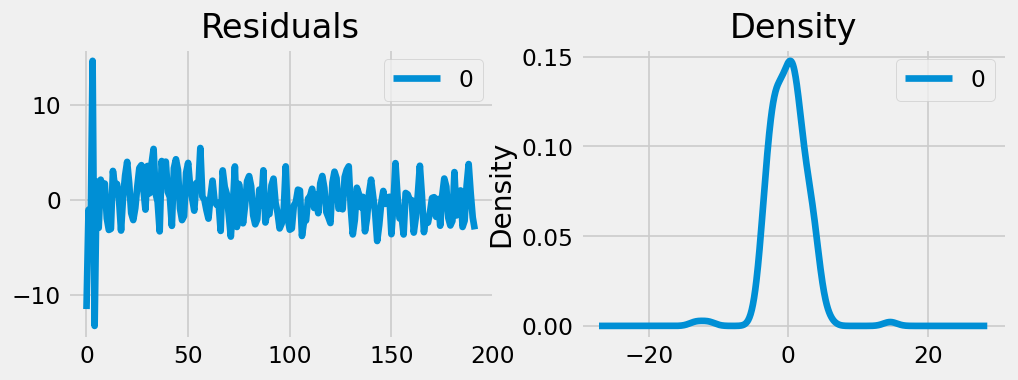

In [23]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

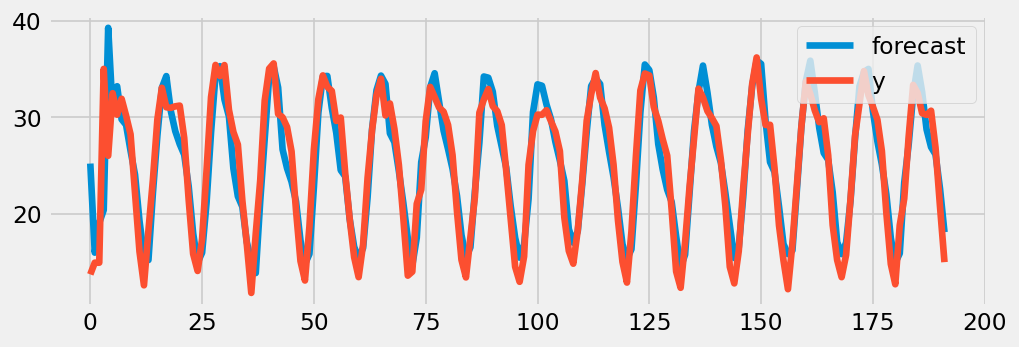

In [24]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

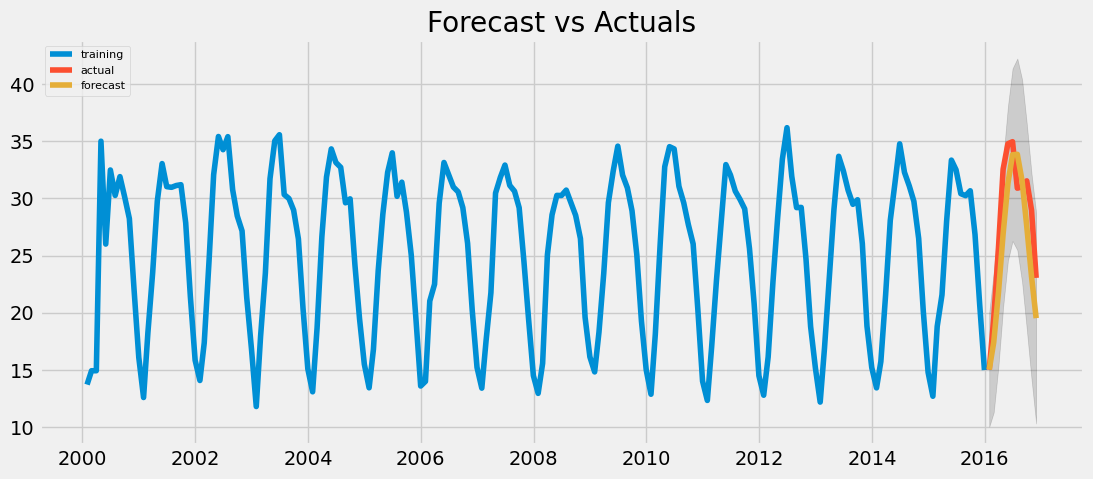

In [25]:
# # Forecast
fc, se, conf = model_fit.forecast(11, alpha=0.05)  # 95% conf

# print(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_df.index)
lower_series = pd.Series(conf[:, 0], index=test_df.index)
upper_series = pd.Series(conf[:, 1], index=test_df.index)

# # Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_df, label='training')
plt.plot(test_df, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
# test_df.index